In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [16]:
annot = pd.read_csv(
    'data/viral_spectra_dataset.csv', 
    usecols=['Type','taxname','df','taxid','virusname']
).query('df == "nemu"')

annot['taxid'] = annot['taxid'].astype(int)
annot.set_index('taxid', inplace=True)
del annot['df']
annot.head()

,Type,taxname,virusname
taxid,,,
10407,ds,Hepatitis B virus,HBV
10990,ds,Rice black streaked dwarf virus,RBSDV
11082,+,West Nile virus,WNV
11983,+,Norwalk virus,norw
12092,+,Hepatovirus A,HAV


In [46]:
obs_aa_freqs = pd.read_csv('./data/aminoacid_freq_all_virus.csv', index_col=0)
    # .join(annot).dropna() # TODO remove dropna whan we update the dataset of amino acid frequencies???
del obs_aa_freqs['refseq_id']
del obs_aa_freqs['X']
print(obs_aa_freqs.shape)
aa_order = obs_aa_freqs.columns[:20]
obs_aa_freqs_long = obs_aa_freqs.melt(
    var_name='amino_acid', 
    value_name='obs_freq',
    ignore_index=False,
).reset_index()
obs_aa_freqs_long

(34, 20)


,taxid,amino_acid,obs_freq
0,10990,M,0.024014
1,11082,M,0.032028
2,11320,M,0.039465
3,1133363,M,0.031650
4,1157337,M,0.029342
...,...,...,...
675,54290,C,0.032718
676,57482,C,0.017490
677,693997,C,0.031864
678,694014,C,0.032858


In [45]:
# TODO recalc this table on new dataset
# TODO recalc OBS table for new dataset

eq_aa_freqs = pd.read_csv('./data/aminoacid_eq_freq_all_virus.csv', index_col=0)[aa_order]
eq_aa_freqs_long = eq_aa_freqs.melt(
    var_name='amino_acid', 
    value_name='eq_freq',
    ignore_index=False,
).reset_index()
eq_aa_freqs_long

,taxid,amino_acid,eq_freq
0,10990,M,0.010919
1,11082,M,0.021009
2,11320,M,0.020867
3,1133363,M,0.011300
4,1157337,M,0.012432
...,...,...,...
575,54290,C,0.042232
576,57482,C,0.036417
577,693997,C,0.034267
578,694014,C,0.041443


<Axes: xlabel='obs_freq', ylabel='eq_freq'>

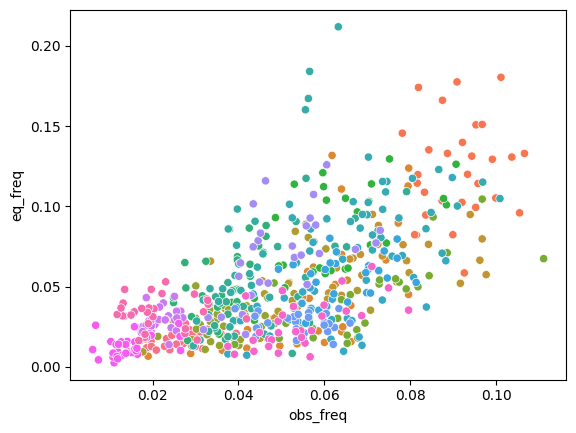

In [51]:
_df_compare = obs_aa_freqs_long.merge(eq_aa_freqs_long, how='inner', on=['taxid', 'amino_acid'])
sns.scatterplot(_df_compare, x='obs_freq', y='eq_freq', hue='amino_acid', legend=False)

In [57]:
eq_aa_freqs.index.intersection(obs_aa_freqs.index).shape, obs_aa_freqs.shape

((29,), (34, 20))

In [58]:
common_taxids = eq_aa_freqs.index.intersection(obs_aa_freqs.index)
eq_aa_freqs_sample = eq_aa_freqs.loc[common_taxids, aa_order]
obs_aa_freqs_sample = obs_aa_freqs.loc[common_taxids, aa_order]

In [124]:
from itertools import combinations

from scipy.stats import pearsonr, spearmanr

data = []
for t1, t2 in combinations(common_taxids, 2):
    t1_eq_aa_freqs = eq_aa_freqs.loc[t1, aa_order]
    t2_eq_aa_freqs = eq_aa_freqs.loc[t2, aa_order]
    t1_obs_aa_freqs = obs_aa_freqs.loc[t1, aa_order]
    t2_obs_aa_freqs = obs_aa_freqs.loc[t2, aa_order]

    obs_diff = (t1_obs_aa_freqs - t2_obs_aa_freqs)
    eq_diff = (t1_eq_aa_freqs - t2_eq_aa_freqs)

    rho, p = spearmanr(obs_diff, eq_diff)

    # obs_diff['taxid1'] = t1
    # obs_diff['taxid2'] = t2
    # eq_diff['taxid1'] = t1
    # eq_diff['taxid2'] = t2

    data.append([t1, t2, rho, p])

df = pd.DataFrame(data, columns=['taxid1', 'taxid2', 'spearmanr', 'spearman_pval'])
df['virusname1'] = df['taxid1'].map(annot['virusname'])
df['virusname2'] = df['taxid2'].map(annot['virusname'])
df['taxname1'] = df['taxid1'].map(annot['taxname'])
df['taxname2'] = df['taxid2'].map(annot['taxname'])
df['type1'] = df['taxid1'].map(annot['Type'])
df['type2'] = df['taxid2'].map(annot['Type'])
df = df.dropna()
df['pair'] = df.apply(lambda x: str(sorted([x['type1'], x['type2']])), axis=1)
df

,taxid1,taxid2,spearmanr,spearman_pval,virusname1,virusname2,taxname1,taxname2,type1,type2,pair
0,10990,11082,0.679699,0.000978,RBSDV,WNV,Rice black streaked dwarf virus,West Nile virus,ds,+,"['+', 'ds']"
2,10990,1133363,0.272180,0.245669,RBSDV,SBV,Rice black streaked dwarf virus,Schmallenberg orthobunyavirus,ds,-,"['-', 'ds']"
3,10990,1157337,0.669173,0.001253,RBSDV,PRV,Rice black streaked dwarf virus,Piscine orthoreovirus,ds,ds,"['ds', 'ds']"
4,10990,118655,0.339850,0.142637,RBSDV,OROV,Rice black streaked dwarf virus,Oropouche orthobunyavirus,ds,-,"['-', 'ds']"
5,10990,11983,0.781955,0.000046,RBSDV,norw,Rice black streaked dwarf virus,Norwalk virus,ds,+,"['+', 'ds']"
...,...,...,...,...,...,...,...,...,...,...,...
401,57482,694014,0.273684,0.242966,EBLV1,ACoV,European bat 1 lyssavirus,Avian coronavirus,-,+,"['+', '-']"
402,57482,77763,0.359398,0.119633,EBLV1,BAV,European bat 1 lyssavirus,Banna virus,-,ds,"['-', 'ds']"
403,693997,694014,0.099248,0.677189,alCoV1,ACoV,Alphacoronavirus 1,Avian coronavirus,+,+,"['+', '+']"
404,693997,77763,0.015038,0.949828,alCoV1,BAV,Alphacoronavirus 1,Banna virus,+,ds,"['+', 'ds']"


In [125]:
df.groupby('pair').spearmanr.agg(['mean', 'std', 'min', 'median', 'max'])\
    .sort_values('mean', ascending=False).round(2)

,mean,std,min,median,max
pair,,,,,
"['+', '-']",0.46,0.28,-0.23,0.51,0.93
"['+', '+']",0.46,0.29,-0.34,0.52,0.90
"['ds', 'ds']",0.46,0.34,-0.29,0.60,0.82
"['+', 'ds']",0.41,0.29,-0.55,0.44,0.83
"['-', 'ds']",0.34,0.27,-0.29,0.36,0.73
"['-', '-']",0.20,0.38,-0.57,0.29,0.75


<Axes: xlabel='pair', ylabel='spearmanr'>

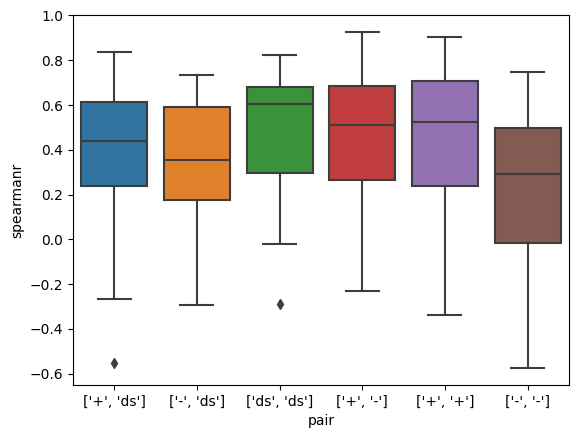

In [119]:
sns.boxplot(
    data=df,
    x='pair',
    y='spearmanr',
)

In [126]:
df.sort_values('spearmanr', ascending=False).head(20)

,taxid1,taxid2,spearmanr,spearman_pval,virusname1,virusname2,taxname1,taxname2,type1,type2,pair
317,1933178,28344,0.926316,4.644140e-09,aka,PRRSV,Akabane orthobunyavirus,Porcine reproductive and respiratory syndrome ...,-,+,"['+', '-']"
323,1933178,54290,0.917293,1.270058e-08,aka,HGV,Akabane orthobunyavirus,GB virus C,-,+,"['+', '-']"
271,138951,1678143,0.903759,4.722818e-08,evD,HEV,Enterovirus D,Orthohepevirus A,+,+,"['+', '+']"
265,138950,54290,0.903759,4.722818e-08,evC,HGV,Enterovirus C,GB virus C,+,+,"['+', '+']"
242,138948,28344,0.881203,2.886085e-07,evA,PRRSV,Enterovirus A,Porcine reproductive and respiratory syndrome ...,+,+,"['+', '+']"
230,12637,54290,0.875188,4.400102e-07,denv,HGV,Dengue virus,GB virus C,+,+,"['+', '+']"
296,162145,54290,0.860150,1.156723e-06,HMV,HGV,Human metapneumovirus,GB virus C,-,+,"['+', '-']"
148,118655,54290,0.854135,1.651322e-06,OROV,HGV,Oropouche orthobunyavirus,GB virus C,-,+,"['+', '-']"
352,28344,3052763,0.845113,2.737644e-06,PRRSV,RSV,Porcine reproductive and respiratory syndrome ...,Rice stripe tenuivirus,+,-,"['+', '-']"
101,1133363,54290,0.840602,3.483776e-06,SBV,HGV,Schmallenberg orthobunyavirus,GB virus C,-,+,"['+', '-']"


In [ ]:
# TODO correlate this spearmanr with the cossim between vituses in the pair